
<i>Updated 29/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# Cycle Generative Adversarial Network for VidTIMIT dataset with Tensorflow 2 on Google Colab (WGAN-GP)

Train Cycle Generative Adversarial Network (CycleGAN) on VidTIMIT dataset.

## VidTIMIT データセットに対して Cycle Generative Adversarial Network をGoogle Colab 上の Tensorflow 2 で学習する

VidTIMIT データセットに対して Cycle Generative Adversarial Network (CycleGAN) を学習する。




In [1]:
#! pip install tensorflow==2.7.0

In [2]:
! pip install tensorflow_addons

In [3]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import numpy as np

np.random.seed(2022)

# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [5]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 29 12:44:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive.
Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

# Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に、Google Drive から <code>gdown</code> してください。
Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [8]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1aNvpPDNeDWYQFu_PA1kOtFlzcO5seHky'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/CycleGAN.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1aNvpPDNeDWYQFu_PA1kOtFlzcO5seHky
To: /content/nw/CycleGAN.py
100% 24.6k/24.6k [00:00<00:00, 37.7MB/s]


In [9]:
! cat {nw_path}/CycleGAN.py

import tensorflow as tf
import tensorflow_addons as tf_addons
import numpy as np

import matplotlib.pyplot as plt

from collections import deque

import os
import pickle as pkl
import random
import datetime


################################################################################
# Data Loader
################################################################################
class PairDataset():
    def __init__(self, paths_A, paths_B, batch_size= 1, target_size = None, unaligned=False):
        self.paths_A = np.array(paths_A)
        self.paths_B = np.array(paths_B)
        self.target_size = target_size
        self.batch_size = batch_size
        self.unaligned = unaligned

        self.lenA = len(paths_A)
        self.lenB = len(paths_B)
        self.index = 0

    def __len__(self):
        return max(self.lenA, self.lenB)

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(self.__len__())
            if sta

# Preparing VidTIMIT dataset

Official WWW of VidTIMIT dataset: http://conradsanderson.id.au/vidtimit/

zip files of 2 persons of VidTIMIT dataset: <br />
https://zenodo.org/record/158963/files/fadg0.zip  <br />
https://zenodo.org/record/158963/files/faks0.zip  <br />

zip files mirrored on my Google Drive: <br />
https://drive.google.com/uc?id=

## VidTIMIT データセットを用意する

VidTIMIT データセットの公式ページ: http://conradsanderson.id.au/vidtimit/

VidTIMIT の2名の顔写真の zip ファイル: <br />
https://zenodo.org/record/158963/files/fadg0.zip <br />
https://zenodo.org/record/158963/files/faks0.zip <br />


自分の Google Drive 上にミラーした顔写真: <br />
https://drive.google.com/uc?id=
https://drive.google.com/uc?id=



In [10]:
# Download zip files
VidTIMIT_site = 'https://zenodo.org/record/158963/files/'
VidTIMIT_fnames = [ 'fadg0', 'faks0']

Mirrored_files = [
    'https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj', 
    'https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz'
]

data_dir = './datasets'
! rm -rf $data_dir
! mkdir -p $data_dir

for i, fname in enumerate(VidTIMIT_fnames):
    fzip = fname + '.zip'
    if False:
        url = VidTIMIT_site + fzip
        !wget {url}
    else:
        url = Mirrored_files[i]
        !gdown {url}

    !unzip -q {fzip} -d {data_dir}

Downloading...
From: https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj
To: /content/fadg0.zip
100% 81.6M/81.6M [00:00<00:00, 219MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz
To: /content/faks0.zip
100% 64.2M/64.2M [00:00<00:00, 174MB/s]


In [11]:
! ls {data_dir}

fadg0  faks0


In [12]:
! ls {data_dir}/fadg0

audio  video


In [13]:
! ls {data_dir}/fadg0/video

head   head3  sa2     si1909  sx109  sx199  sx379
head2  sa1    si1279  si649   sx19   sx289


In [14]:
! ls {data_dir}/fadg0/video/head | head -5

001
002
003
004
005


In [15]:
! ls {data_dir}/fadg0/video/sx19 | head -5

001
002
003
004
005


# Check the images of VidTIMIT

## VidTIMIT の画像をチェックする

In [16]:
# Display images
# 画像を表示する。
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showImages(imgs, rows=-1, cols=-1, w=2, h=2):
    N = len(imgs)
    if rows < 0: rows = 1
    if cols < 0: cols = (N + rows -1) // rows
    fig, ax = plt.subplots(rows, cols, figsize=(w*cols, h*rows))
    idx = 0
    for row in range(rows):
        for col in range(cols) :
            if rows == 1 and cols == 1:
                axis = ax
            elif rows == 1:
                axis = ax[col]
            elif cols == 1:
                axis = ax[row]
            else:
                axis = ax[row][col]

            if idx < N:
                axis.imshow(imgs[idx])
            axis.axis('off')
            idx += 1
    plt.show()

In [17]:
# Display images with the file paths.
# 画像のpathの配列を受け取って、画像を表示する。
%matplotlib inline
import tensorflow as tf

def showImagesByPath(fnames,rows=-1, cols=-1, w=2, h=2):
    imgs = [ tf.keras.utils.load_img(fname) for fname in fnames]
    showImages(imgs, rows, cols, w, h)

In [18]:
import os
import glob

! ls {data_dir}/{VidTIMIT_fnames[0]}/video

head   head3  sa2     si1909  sx109  sx199  sx379
head2  sa1    si1279  si649   sx19   sx289


In [19]:
! ls {data_dir}

fadg0  faks0


====fadg0====
sx289  126


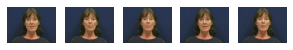

sx19  97


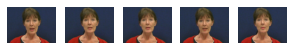

si1279  72


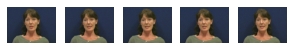

si1909  117


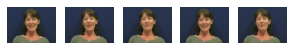

sa1  119


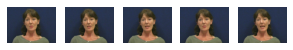

sx109  135


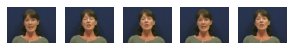

sx199  144


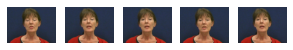

head2  406


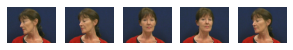

head3  742


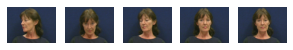

si649  216


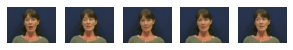

sx379  109


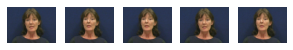

sa2  103


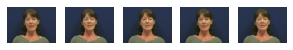

head  346


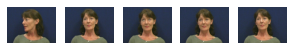

In [20]:
# Images of A
person = VidTIMIT_fnames[0]

print(f'===={person}====')
paths = glob.glob(os.path.join(f'{data_dir}/{person}/video', '*'))
for path in paths:
    dpath, dir = os.path.split(path)
    fpath = glob.glob(os.path.join(path, '*'))
    print(f'{dir}  {len(fpath)}')
    showImagesByPath(fpath[:5],-1,-1,1,1)

====faks0====
sx133  97


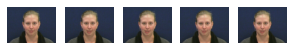

sa1  89


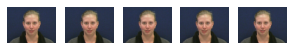

sx313  90


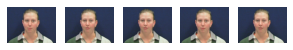

head2  358


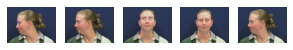

si2203  81


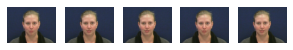

head3  369


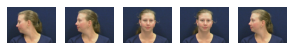

sx403  97


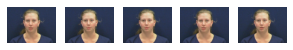

sa2  81


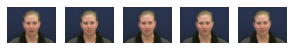

sx223  89


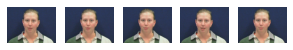

si1573  145


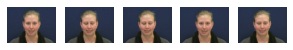

head  458


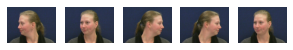

si943  98


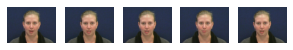

sx43  86


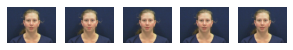

In [21]:
# Images of B
person = VidTIMIT_fnames[1]

print(f'===={person}====')
paths = glob.glob(os.path.join(f'{data_dir}/{person}/video', '*'))
for path in paths:
    dpath, dir = os.path.split(path)
    fpath = glob.glob(os.path.join(path, '*'))
    print(f'{dir}  {len(fpath)}')
    showImagesByPath(fpath[:5],-1,-1,1,1)

# Make DataGenerator from the images of VidTIMIT

## VidTIMIT の画像ファイルから DataGenerator を作る

In [22]:
IMAGE_SIZE = 128

In [23]:
import os
import glob

imgA_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[0], 'video/*/[0-9]*'))
imgB_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[1], 'video/*/[0-9]*'))

In [24]:
import numpy as np

validation_split = 0.05

nA, nB = len(imgA_paths), len(imgB_paths)
splitA = int(nA * (1 - validation_split))
splitB = int(nB * (1 - validation_split))

np.random.shuffle(imgA_paths)
np.random.shuffle(imgB_paths)

train_imgA_paths = imgA_paths[:splitA]
test_imgA_paths = imgA_paths[splitA:]
train_imgB_paths = imgB_paths[:splitB]
test_imgB_paths = imgB_paths[splitB:]

In [25]:
# Image: [-1, 1] --> [0, 1]
def M1P1_ZeroP1(imgs):
    imgs = (imgs + 1) * 0.5
    return np.clip(imgs, 0, 1)

# Image: [0, 1] --> [-1, 1]
def ZeroP1_M1P1(imgs):
    return imgs * 2 - 1

In [26]:
from nw.CycleGAN import PairDataset

pair_flow = PairDataset(train_imgA_paths, train_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))
test_pair_flow = PairDataset(test_imgA_paths, test_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))

(128, 128, 3) (128, 128, 3)


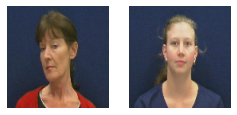

In [27]:
a, b = next(pair_flow)
print(a.shape, b.shape)
showImages([M1P1_ZeroP1(a), M1P1_ZeroP1(b)])

(5, 2, 128, 128, 3)
(10, 128, 128, 3)


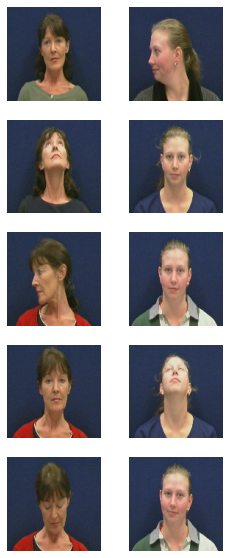

In [28]:
pairs = pair_flow[10:15]
shape = pairs.shape
print(shape)

a = pairs.reshape(-1, *shape[2:])
print(a.shape)
showImages(M1P1_ZeroP1(a), 5, 2)

# Define the Neural Network Model

## ニューラルネットワーク・モデルを定義する

In [29]:
from nw.CycleGAN import CycleGAN

gan = CycleGAN(
    input_dim = (IMAGE_SIZE, IMAGE_SIZE, 3),
    learning_rate = 0.0002,
    buffer_max_length = 50,
    lambda_validation = 1,
    lambda_reconstr = 10,
    lambda_id = 2,
    generator_type = 'unet',
    gen_n_filters = 32,
    disc_n_filters = 32
)

In [30]:
gan.d_A.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 instance_normalization (Ins  (None, 32, 32, 64)       0         
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                             

In [31]:
gan.d_B.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        1568      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 instance_normalization_3 (I  (None, 32, 32, 64)       0         
 nstanceNormalization)                                           
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                           

In [32]:
gan.g_AB.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 32)   1568        ['input_3[0][0]']                
                                                                                                  
 instance_normalization_6 (Inst  (None, 64, 64, 32)  0           ['conv2d_10[0][0]']              
 anceNormalization)                                                                               
                                                                                            

In [33]:
gan.g_BA.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 64, 64, 32)   1568        ['input_4[0][0]']                
                                                                                                  
 instance_normalization_13 (Ins  (None, 64, 64, 32)  0           ['conv2d_18[0][0]']              
 tanceNormalization)                                                                              
                                                                                            

In [34]:
gan.combined.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 128, 128, 3)  1545411     ['input_6[0][0]',                
                                                                  'model_2[0][0]',          

# Train

## 訓練する

In [35]:
save_path = '/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01'

In [36]:
! rm -rf {save_path}

# Train for a few epochs

# 少ないエポック回数だけ学習させる

In [37]:
gan.train(
    pair_flow,
    epochs=1,
    batch_size=1,
    run_folder = save_path
)

Epoch 1/1 100/2595 [D loss: 0.257 acc: 0.555][G loss: 2.595 adv: 0.902 recon: 0.138 id: 0.156 time: 0:00:29.597120
Epoch 1/1 200/2595 [D loss: 0.156 acc: 0.812][G loss: 2.454 adv: 0.485 recon: 0.163 id: 0.167 time: 0:00:48.062442
Epoch 1/1 300/2595 [D loss: 0.202 acc: 0.663][G loss: 2.156 adv: 0.726 recon: 0.118 id: 0.124 time: 0:01:06.676460
Epoch 1/1 400/2595 [D loss: 0.123 acc: 0.864][G loss: 1.798 adv: 0.463 recon: 0.112 id: 0.110 time: 0:01:25.102150
Epoch 1/1 500/2595 [D loss: 0.126 acc: 0.889][G loss: 1.966 adv: 0.569 recon: 0.115 id: 0.123 time: 0:01:43.598282
Epoch 1/1 600/2595 [D loss: 0.123 acc: 0.874][G loss: 2.198 adv: 0.911 recon: 0.109 id: 0.099 time: 0:02:02.081157
Epoch 1/1 700/2595 [D loss: 0.207 acc: 0.704][G loss: 2.535 adv: 0.853 recon: 0.142 id: 0.130 time: 0:02:20.621453
Epoch 1/1 800/2595 [D loss: 0.145 acc: 0.797][G loss: 2.127 adv: 0.800 recon: 0.113 id: 0.101 time: 0:02:38.969913
Epoch 1/1 900/2595 [D loss: 0.205 acc: 0.652][G loss: 1.895 adv: 0.474 recon: 0.

In [38]:
! ls {save_path}/weights

combined-weights_1.h5  d_A-weights.h5	 g_AB-weights_1.h5  g_BA-weights.h5
combined-weights.h5    d_B-weights_1.h5  g_AB-weights.h5
d_A-weights_1.h5       d_B-weights.h5	 g_BA-weights_1.h5


In [39]:
gan.train(
    pair_flow,
    epochs=3,
    batch_size=1,
    run_folder = save_path,
    print_step_interval=500
)

Epoch 2/3 500/2595 [D loss: 0.145 acc: 0.794][G loss: 2.187 adv: 0.990 recon: 0.102 id: 0.089 time: 0:01:33.490890
Epoch 2/3 1000/2595 [D loss: 0.046 acc: 0.961][G loss: 1.614 adv: 0.548 recon: 0.091 id: 0.077 time: 0:03:05.658150
Epoch 2/3 1500/2595 [D loss: 0.035 acc: 0.999][G loss: 1.228 adv: 0.295 recon: 0.079 id: 0.073 time: 0:04:38.242862
Epoch 2/3 2000/2595 [D loss: 0.086 acc: 0.928][G loss: 1.748 adv: 0.481 recon: 0.107 id: 0.099 time: 0:06:10.717727
Epoch 2/3 2500/2595 [D loss: 0.125 acc: 0.853][G loss: 1.760 adv: 0.658 recon: 0.094 id: 0.084 time: 0:07:43.549074
Epoch 2/3 [D loss: 0.112 acc: 0.869][G loss: 1.857 adv: 0.764 recon: 0.093 id: 0.084 time: 0:08:00.853371
Epoch 3/3 500/2595 [D loss: 0.091 acc: 0.905][G loss: 1.638 adv: 0.532 recon: 0.092 id: 0.092 time: 0:09:32.711431
Epoch 3/3 1000/2595 [D loss: 0.094 acc: 0.897][G loss: 2.009 adv: 1.012 recon: 0.084 id: 0.079 time: 0:11:05.072448
Epoch 3/3 1500/2595 [D loss: 0.117 acc: 0.829][G loss: 1.813 adv: 0.951 recon: 0.072

# Generate Images

## 画像を生成する

A-->B-->A, ID


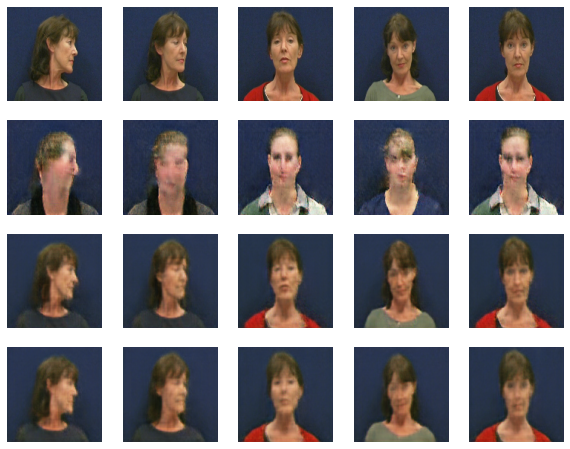

B-->A-->B, ID


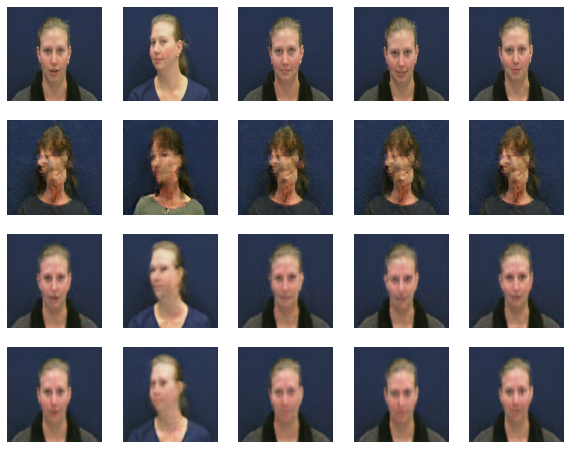

In [40]:
# Display generated and cycle images.
# 生成画像とサイクル画像を表示する。

test_pairs = test_pair_flow[:5]

test_imgsA = test_pairs[:,0]
test_imgsB = test_pairs[:,1]

imgsAB = gan.generate_image_from_A(test_imgsA)
imgsBA = gan.generate_image_from_B(test_imgsB)

print('A-->B-->A, ID')
showImages(M1P1_ZeroP1(imgsAB), 4)

print('B-->A-->B, ID')
showImages(M1P1_ZeroP1(imgsBA), 4)

# Check the loss and accuracy of the training process.

## 学習過程のlossと精度を確認する

loss AB


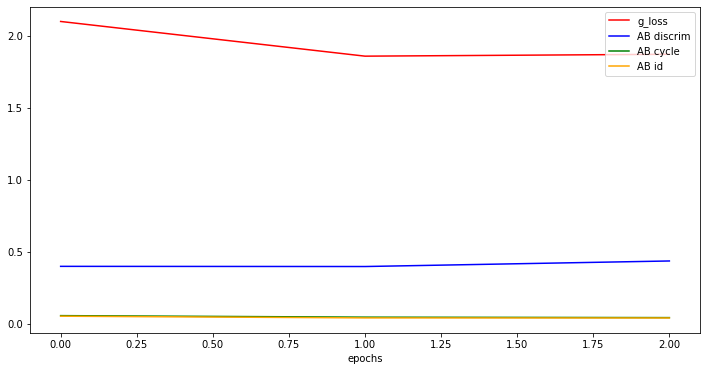

loss BA


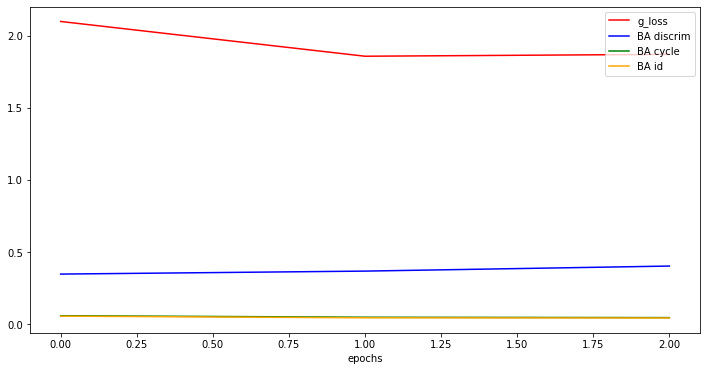

In [41]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss()

# Check the saved files

## 保存されているファイルを確認する

In [42]:
! ls -lR {save_path}

/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01:
total 7
-rw------- 1 root root  413 Nov 29 12:52 params_1.pkl
-rw------- 1 root root  895 Nov 29 13:08 params_3.pkl
-rw------- 1 root root  895 Nov 29 13:08 params.pkl
drwx------ 2 root root 4096 Nov 29 13:08 weights

/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01/weights:
total 105618
-rw------- 1 root root 17974272 Nov 29 12:52 combined-weights_1.h5
-rw------- 1 root root 17974272 Nov 29 13:08 combined-weights_3.h5
-rw------- 1 root root 17974272 Nov 29 13:08 combined-weights.h5
-rw------- 1 root root  2805136 Nov 29 12:52 d_A-weights_1.h5
-rw------- 1 root root  2805136 Nov 29 13:08 d_A-weights_3.h5
-rw------- 1 root root  2805136 Nov 29 13:08 d_A-weights.h5
-rw------- 1 root root  2805136 Nov 29 12:52 d_B-weights_1.h5
-rw------- 1 root root  2805136 Nov 29 13:08 d_B-weights_3.h5
-rw------- 1 root root  2805136 Nov 29 13:08 d_B-weights.h5
-rw------- 1 root root  6232880 Nov 29 12:52 g_AB-weights_1.h5
-rw------- 1 root root  6

# Load the saved file and try further training.

Load the saved parameters and model weights, and try training further.

## セーブしたファイルをロードして、さらに学習を進める

保存してあるパラメータとモデルの重みをロードして、追加の学習を試みる。

In [43]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

gan_work = CycleGAN.load(save_path)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(gan_work.epoch)

3


In [44]:
# Training in addition
# 追加で training する。

gan_work.train(
    pair_flow,
    epochs=5,
    batch_size=1,
    run_folder = save_path,
    print_step_interval=500,
    save_epoch_interval = 5
)

Epoch 4/5 500/2595 [D loss: 0.145 acc: 0.812][G loss: 1.774 adv: 0.681 recon: 0.091 id: 0.090 time: 0:01:42.066682
Epoch 4/5 1000/2595 [D loss: 0.043 acc: 1.000][G loss: 2.676 adv: 1.659 recon: 0.085 id: 0.084 time: 0:03:13.842908
Epoch 4/5 1500/2595 [D loss: 0.092 acc: 0.920][G loss: 1.699 adv: 0.822 recon: 0.073 id: 0.072 time: 0:04:46.132772
Epoch 4/5 2000/2595 [D loss: 0.074 acc: 0.953][G loss: 2.001 adv: 0.781 recon: 0.102 id: 0.100 time: 0:06:18.087056
Epoch 4/5 2500/2595 [D loss: 0.073 acc: 0.957][G loss: 1.870 adv: 0.907 recon: 0.080 id: 0.081 time: 0:07:50.475077
Epoch 4/5 [D loss: 0.088 acc: 0.911][G loss: 1.905 adv: 0.908 recon: 0.084 id: 0.081 time: 0:08:07.897072
Epoch 5/5 500/2595 [D loss: 0.078 acc: 0.943][G loss: 2.253 adv: 1.262 recon: 0.082 id: 0.085 time: 0:09:40.228815
Epoch 5/5 1000/2595 [D loss: 0.071 acc: 0.944][G loss: 2.606 adv: 1.626 recon: 0.082 id: 0.082 time: 0:11:12.493290
Epoch 5/5 1500/2595 [D loss: 0.056 acc: 0.993][G loss: 1.197 adv: 0.355 recon: 0.070

A-->B-->A, ID


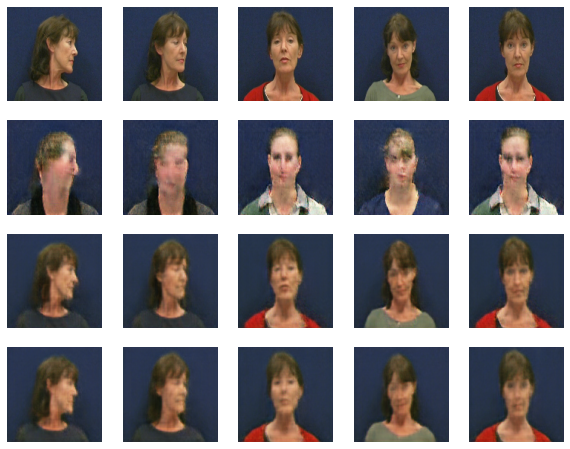

B-->A-->B, ID


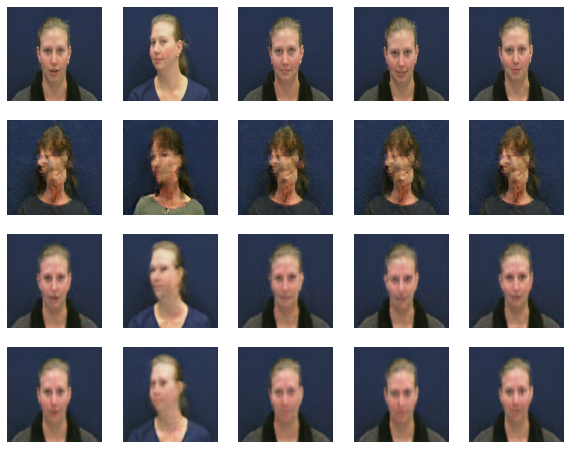

In [45]:
# Display generated and cycle images.
# 生成画像とサイクル画像を表示する。

test_pairs = test_pair_flow[:5]

test_imgsA = test_pairs[:,0]
test_imgsB = test_pairs[:,1]

imgsAB = gan.generate_image_from_A(test_imgsA)
imgsBA = gan.generate_image_from_B(test_imgsB)

print('A-->B-->A, ID')
showImages(M1P1_ZeroP1(imgsAB), 4)

print('B-->A-->B, ID')
showImages(M1P1_ZeroP1(imgsBA), 4)

loss AB


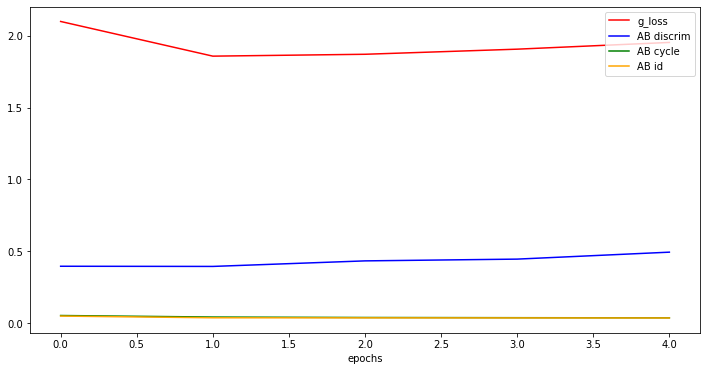

loss BA


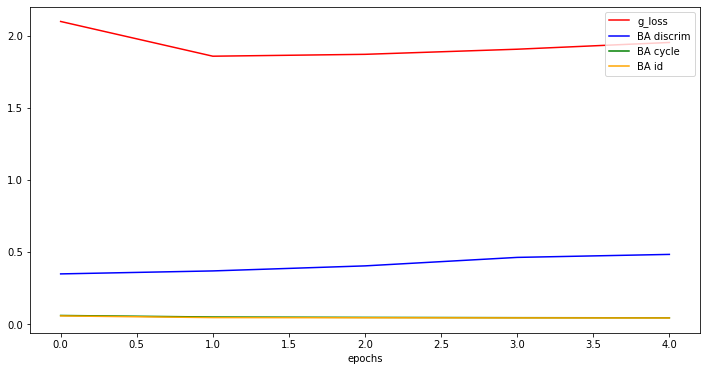

In [46]:
# Display the graph of losses in training
%matplotlib inline

gan_work.showLoss()